# Imports

In [1]:
import csv
import matplotlib.pyplot as plt

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd

%matplotlib inline


from scipy import stats

## Functions

Har problemer med og få lagt inn hit/miss trial fuksjon i dictionary 

er også noe surr med licks per trial fuksjon. 
Skal endres til trial start når pumpa skrus på + 10 sec

skal også endre lick HZ og latency til når pumpa skrus på + 10 sec 

In [2]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks, cues and pumps) in framenumber
    
    args
    filename - string 
    
    returns 
    pump_on_fn - list of integers 
        framenumner of pump on 
    pump_off_fn - list of integers 
        framenumner of pump off
    cue_on_fn - list of integers 
        framenumner of cue on 
    cue_off_fn - list of integers 
        framenumner of cue off
    licks_fn - lits of integers 
        framenumber of licks 
    '''
    file_event = open(filename)
    csvreader_event = csv.reader(file_event)
    header_event = [] 

    
    rows_event=[] 
    for row in csvreader_event:
        rows_event.append(row)
    
    # Pump on/off fn

    pump_on_fn=[]
    pump_off_fn=[]
    for row in rows_event:
        frame_number=row[15]
        if row[0] == 'pump_on':
            pump_on_fn.append(int (frame_number))
        elif row[0] == 'pump_off':
            pump_off_fn.append(int(frame_number))
    # Cue off frame number

    cue_off_fn=[]
    cue_on_fn=[]
    for row in rows_event:
        frame_number=row[15]
        if row[0] == 'Cue_off':
            cue_off_fn.append(int(frame_number))
        elif row[0] == 'Cue_on':
            cue_on_fn.append(int(frame_number))
# Licks frame number
    licks_fn=[]
    for row in rows_event: 
        frame_number=row[15]
        if row[0]=='Lick':
            licks_fn.append(int(frame_number))
    
    return pump_on_fn, licks_fn
        

    

In [3]:
def get_hit_miss_trial (pump_on_fn, licks_fn, trialstart=0, trialend= 100):
    '''
    function to get hit and missed trials 
        trials with and without licks
        
    args
    pump_on_fn - list of integer 
        list of framenumber when pump on 
    licks_fn - list of integer 
        list of framenumber on lick 
    trialstart - start of trial relative to pump on (optional, default 0)
    trialend - end of trial relatibe to pump off (optional, default 100)
        
    returns
    hit_trial - list of int 
        list of first framenumber in trial when theres a lick 
    miss_trial - list of int
        list of first framenumber in trials without licks
    
    '''
    
    miss_trial=[]
    hit_trial=[]
    for on in pump_on_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > on and lick < on + 100 : 
                temp.append(lick)
        if len(temp) == 0: 
            miss_trial.append(on)
        elif len(temp) > 0: 
            hit_trial.append(on)
            
    return hit_trial, miss_trial

In [4]:
def get_trial_licks (pump_on_fn, licks, trialstart=0, trialend=100):
    '''
    funtion to get trial licks
    licks aligned to pump on 
    
    arg
    licks - list of floats 
        timestamp of licks in seconds
    pump - list of floats 
        timestamp of pump on in seconds
    trialstart - int float (optional default 0)
    trialend - int folat (optional default 10)
    
    returns 
    licks_trial - list of lists of floats 
        timestamp of licks realtive to pump on (in seconds)
    '''
    licks_trial=[]
    for on in pump_on_fn: 
        temp=[]
        for lick in licks: 
            if lick > on and lick < on + 100:
                temp.append(lick-on)
    licks_trial.append(temp)
    
    return licks_trial

In [5]:
def extract_event_timing(filename):
    '''
    function to extract timing of events (licks, cues and pumps) in seconds
    
    args 
    filename - string?????
    
    returns 
    licks_seconds - list of floats 
        timestamps of licks in seconds
    cues_seconds - list of floats 
        timestamps of cues in seconds 
    pump_seconds - list of floats 
        timestamps of pumps in seconds
    '''
    #Open file
    file_event = open(filename)
    csvreader_event = csv.reader(file_event)
    header_event = [] 
    
    rows_event=[] 
    for row in csvreader_event:
        rows_event.append(row)
        
   #Setting T0     
    T0_row=rows_event[1]
    T0_column=T0_row[14]
    T0=datetime.strptime(T0_column[:26],"%Y-%m-%dT%H:%M:%S.%f")
    
    #Timing of licks 
    licks_time=[]
    for row in rows_event:
        if row[0] == 'Lick':
            timestamp=row[14]
            my_date = datetime.strptime(timestamp[:26], "%Y-%m-%dT%H:%M:%S.%f")
            licks_time.append(my_date)
            
    licks_seconds=[]
    for lick in licks_time:
        F=lick-T0
        F_seconds=F.total_seconds()
        licks_seconds.append(F_seconds)
    total_licks=len(licks_seconds)
    
    #Timing of cues
    cues_timestamp=[]
    for row in rows_event:
        if row[0] == 'Cue_on':
            timestamp=row[14]
            my_date = datetime.strptime(timestamp[:26], "%Y-%m-%dT%H:%M:%S.%f")
            cues_timestamp.append(my_date)
            
    cues_seconds=[]
    for cue in cues_timestamp:
        F=cue-T0
        F_seconds=F.total_seconds()
        cues_seconds.append(F_seconds)
        
    #Timing of pumps
    pump_timestamp=[]
    for row in rows_event: 
        if row[0]== 'pump_on': 
            timestamp=row[14]
            my_date=datetime.strptime(timestamp[:26], "%Y-%m-%dT%H:%M:%S.%f")
            pump_timestamp.append(my_date)
    
    pump_seconds=[]
    for pump in pump_timestamp: 
        F=pump-T0
        F_seconds=F.total_seconds()
        pump_seconds.append(F_seconds)
        
    return licks_seconds, cues_seconds, pump_seconds

In [6]:
def get_cued_licks(licks,cues,precuetime=5,postcuetime=20):
    '''
    function to get licks aligned to cues
    
    args
    licks - list of floats 
        timestamps of licks in seconds 
    cues - list of floats
        timestamps of cues in seconds 
    precuetime - int or float (optional default 5)
        
    returns 
    cued licks - list of lists of floats 
        timestamps of licks realtive to cues (in seconds)
    
    '''   
    cued_licks=[]
    for cue in cues: 
        temp_cued_licks=[]
        for lick in licks: 
            if lick > cue-precuetime:
                if lick < cue+postcuetime:
                    temp_cued_licks.append(lick-cue)
        cued_licks.append(temp_cued_licks)
        
    return cued_licks
        

In [7]:
def get_cue_epoch(cued_licks,epochstart= -5, epochend= 20, outputpertrial=True):
    '''
    function to get licks licks in epochs of each trial 
    
    arg
    cued licks - list of lists of floats 
        timestamps of licks relative to cues (in seconds)
    epochstart - int or float (optional default -5)
    epochend - int or float (optional default 20)
    outputpertrial - statement (True or false) (optional defalut True)
        Calculates avarage licks per epoch per trial 
        
    Retuns
        total_licks_epoch - float
            number of licks for a given epoch of the trial 
        
    '''    
    all_cued_licks=tp.flatten_list(cued_licks)
    
    
    licks_per_epoch=[]
    for licks in all_cued_licks:
        if licks > epochstart:
            if licks < epochend:
                licks_per_epoch.append(licks)
    total_licks_epoch=len(licks_per_epoch)
    
    if outputpertrial==True: 
        n_trials=len(cued_licks)
        total_licks_epoch=total_licks_epoch/n_trials
    
    return total_licks_epoch

In [8]:
def get_licks_Hz (licks_trial):
    '''
    function to get lick fequency in Hz
    
    args
    licks_trial - list of lists of floats 
        timestamps of licks realtive to pump on (in seconds)
        
    returns 
    licks_Hz - list of lists of folats     
    '''
    
    all_cued_licks=tp.flatten_list(licks_trial)
    bins=np.arange(-5,21, 0.1)
    hist_data=np.histogram(all_cued_licks,bins=bins)
    licks_bin=hist_data[0]/len(cued_licks)

    licks_Hz=licks_bin*10
    
    return licks_Hz

In [9]:
def get_latency(cued_licks):
    latency=[]
    for trial in cued_licks:
        temp_latency=[]
        for lick in trial: 
            if lick > 0:
                temp_latency.append(lick)
        if len(temp_latency) > 0:
            latency.append(temp_latency[0])
    return latency

## Metafile reader

In [10]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Behavior')

File is excel file. Making csv metafile first


In [11]:
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

## Making dictionary

In [12]:
all_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[4]
        
        licks,cues,pump=extract_event_timing(folder+row[1])
        cued_licks=get_cued_licks(licks, cues)
        get_cue_epoch(cued_licks,epochstart=0,epochend=10)
        
        
        pump_on_fn,licks_fn=extract_event_fn(folder+row[1])
        hit_trial, miss_trial=get_hit_miss_trial(pump_on_fn, licks_fn, trialstart=0, trialend=100 )
#         licks_trial=get_trial_licks (pump_on_fn, licks)

        
                
        all_data[key]={}
        all_data[key]['mouse']=row[0]
        all_data[key]['day']=row[4]
        all_data[key]['diet']=row[7]
        all_data[key]['phase']=row[6]
        all_data[key]['session']=row[10]
        all_data[key]['solution']=row[8]
        
        all_data[key]['total licks']=len(licks)
        all_data[key]['licks per trial']=get_cue_epoch(cued_licks,epochstart=5,epochend=15)
        
        all_data[key]['licks BC']=get_cue_epoch(cued_licks,epochstart=-5,epochend=0)
        all_data[key]['licks DC']=get_cue_epoch(cued_licks,epochstart=0,epochend=5)
        all_data[key]['licks AC']=get_cue_epoch(cued_licks,epochstart=5,epochend=20)
        
        all_data[key]['licks Hz']=get_licks_Hz(cued_licks)
        
        all_data[key]['latency']=get_latency(cued_licks)
        
        all_data[key]['hit trial']= len(hit_trial)
        all_data[key]['miss trial']= len(miss_trial)
#         all_data[key]['licks trial']= len(licks_trial)
        
                         
        
    except FileNotFoundError:
        print('cannot find file for', key)
        

In [23]:
# all_data

In [14]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)

### Hit/miss trials

S1

In [15]:
hit_S1_PR=[]
hit_S1_NR=[]

hit_S1_PR_E=[]
hit_S1_NR_E=[]
hit_S1_PRNR_E=[]
hit_S1_NRPR_E=[]

hit_S1_PR_C=[]
hit_S1_NR_C=[]

hit_S1_PR_M=[]
hit_S1_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S1'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            hit_S1_PR.append(d['hit trial'])
        elif d['diet']== 'NR': 
            hit_S1_NR.append(d['hit trial'])
            
    if d['session']=='S1'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            hit_S1_PR_E.append(d['hit trial'])
        elif d['diet']== 'NR': 
            hit_S1_NR_E.append(d['hit trial'])
        elif d['diet']== 'PRNR':
            hit_S1_PRNR_E.append(d['hit trial'])
        elif d['diet']== 'NRPR':
            hit_S1_NRPR_E.append(d['hit trial'])
                
    if d['session']== 'S1' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            hit_S1_PR_C.append(d['hit trial'])
        elif d['diet']== 'NR':
            hit_S1_NR_C.append(d['hit trial'])

    if d['session']== 'S1' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            hit_S1_PR_M.append(d['hit trial'])
        elif d['diet']== 'NR':
            hit_S1_NR_M.append(d['hit trial'])

print('Baseline', 'PR', np.mean(hit_S1_PR),' NR',np.mean(hit_S1_NR))
print('Ensure', 'PR', np.mean(hit_S1_PR_E),' NR',np.mean(hit_S1_NR_E))
print('Ensure 2', 'PRNR', np.mean(hit_S1_PRNR_E), 'NRPR', np.mean(hit_S1_NRPR_E))
print('Casein', 'PR',np.mean(hit_S1_PR_C),' NR',np.mean(hit_S1_NR_C))
print('Malt.', 'PR', np.mean(hit_S1_PR_M),' NR', np.mean(hit_S1_NR_M))


hit_S1_NRPR_E


Baseline PR 33.6  NR 23.75
Ensure PR 29.2  NR 12.5
Ensure 2 PRNR 27.2 NRPR 28.0
Casein PR 22.6  NR 17.0
Malt. PR 18.4  NR 17.25


[15, 38, 31]

In [16]:
hit_S2_PR=[]
hit_S2_NR=[]

hit_S2_PR_E=[]
hit_S2_NR_E=[]

hit_S2_PR_C=[]
hit_S2_NR_C=[]

hit_S2_PR_M=[]
hit_S2_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S2'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            hit_S2_PR.append(d['hit trial'])
        elif d['diet']== 'NR': 
            hit_S2_NR.append(d['hit trial'])
            
    if d['session']=='S2'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            hit_S2_PR_E.append(d['hit trial'])
        elif d['diet']== 'NR': 
            hit_S2_NR_E.append(d['hit trial'])
                
    if d['session']== 'S2' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            hit_S2_PR_C.append(d['hit trial'])
        elif d['diet']== 'NR':
            hit_S2_NR_C.append(d['hit trial'])

    if d['session']== 'S2' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            hit_S2_PR_M.append(d['hit trial'])
        elif d['diet']== 'NR':
            hit_S2_NR_M.append(d['hit trial'])

print('Baseline', 'PR', np.mean(hit_S2_PR),' NR',np.mean(hit_S2_NR))
print('Ensure', 'PR', np.mean(hit_S2_PR_E),' NR',np.mean(hit_S2_NR_E))
print('Casein', 'PR',np.mean(hit_S2_PR_C),' NR',np.mean(hit_S2_NR_C))
print('Malt.', 'PR', np.mean(hit_S2_PR_M),' NR', np.mean(hit_S2_NR_M))



Baseline PR 33.8  NR 27.0
Ensure PR 31.6  NR 17.25
Casein PR 13.6  NR 13.75
Malt. PR 17.8  NR 16.5


In [17]:
hit_S3_PR=[]
hit_S3_NR=[]

hit_S3_PR_E=[]
hit_S3_NR_E=[]

hit_S3_PR_C=[]
hit_S3_NR_C=[]

hit_S3_PR_M=[]
hit_S3_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S3'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            hit_S3_PR.append(d['hit trial'])
        elif d['diet']== 'NR': 
            hit_S3_NR.append(d['hit trial'])
            
    if d['session']=='S3'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            hit_S3_PR_E.append(d['hit trial'])
        elif d['diet']== 'NR': 
            hit_S3_NR_E.append(d['hit trial'])
                
    if d['session']== 'S3' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            hit_S3_PR_C.append(d['hit trial'])
        elif d['diet']== 'NR':
            hit_S3_NR_C.append(d['hit trial'])

    if d['session']== 'S3' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            hit_S3_PR_M.append(d['hit trial'])
        elif d['diet']== 'NR':
            hit_S3_NR_M.append(d['hit trial'])

print('Baseline', 'PR', np.mean(hit_S3_PR),' NR',np.mean(hit_S3_NR))
print('Ensure', 'PR', np.mean(hit_S3_PR_E),' NR',np.mean(hit_S3_NR_E))
print('Casein', 'PR',np.mean(hit_S3_PR_C),' NR',np.mean(hit_S3_NR_C))
print('Malt.', 'PR', np.mean(hit_S3_PR_M),' NR', np.mean(hit_S3_NR_M))



Baseline PR 34.6  NR 37.75
Ensure PR 27.2  NR 28.5
Casein PR 17.2  NR 14.25
Malt. PR 13.6  NR 14.25


### Total licks

Session 1

In [18]:
total_licks_S1_PR=[]
total_licks_S1_NR=[]

total_licks_S1_PR_E=[]
total_licks_S1_NR_E=[]

total_licks_S1_PR_C=[]
total_licks_S1_NR_C=[]

total_licks_S1_PR_M=[]
total_licks_S1_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S1'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            total_licks_S1_PR.append(d['total licks'])
        elif d['diet']== 'NR': 
            total_licks_S1_NR.append(d['total licks'])
            
    if d['session']=='S1'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            total_licks_S1_PR_E.append(d['total licks'])
        elif d['diet']== 'NR': 
            total_licks_S1_NR_E.append(d['total licks'])
                
    if d['session']== 'S1' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            total_licks_S1_PR_C.append(d['total licks'])
        elif d['diet']== 'NR':
            total_licks_S1_NR_C.append(d['total licks'])
     
    if d['session']== 'S1' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            total_licks_S1_PR_M.append(d['total licks'])
        elif d['diet']== 'NR':
            total_licks_S1_NR_M.append(d['total licks'])
                
print(total_licks_S1_PR,total_licks_S1_NR)
print(total_licks_S1_PR_E,total_licks_S1_NR_E)
print(total_licks_S1_PR_C, total_licks_S1_NR_C)
print(total_licks_S1_PR_M,total_licks_S1_NR_M )

[310, 948, 803, 856, 1654] [153, 26, 1034, 736]
[966, 204, 400, 804, 1021] [57, 23, 41, 500]
[513, 174, 232, 230, 814] [211, 133, 192, 261]
[210, 182, 128, 458, 421] [180, 170, 207, 185]


Session 2 ensure

In [19]:
total_licks_S2_PR=[]
total_licks_S2_NR=[]
total_licks_S2_PR_E=[]
total_licks_S2_NR_E=[]

total_licks_S2_PR_C=[]
total_licks_S2_NR_C=[]

total_licks_S2_PR_M=[]
total_licks_S2_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S2'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            total_licks_S2_PR.append(d['total licks'])
        elif d['diet']== 'NR': 
            total_licks_S2_NR.append(d['total licks'])
            
    if d['session']=='S2'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            total_licks_S2_PR_E.append(d['total licks'])
        elif d['diet']== 'NR': 
            total_licks_S2_NR_E.append(d['total licks'])
            
    if d['session']== 'S2' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            total_licks_S2_PR_C.append(d['total licks'])
        elif d['diet']== 'NR':
            total_licks_S2_NR_C.append(d['total licks'])
     
    if d['session']== 'S2' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            total_licks_S2_PR_M.append(d['total licks'])
        elif d['diet']== 'NR':
            total_licks_S2_NR_M.append(d['total licks'])
            
print(total_licks_S2_PR,total_licks_S2_NR )  
print(total_licks_S2_PR_E,total_licks_S2_NR_E)
print(total_licks_S2_PR_C,total_licks_S2_NR_C)
print(total_licks_S2_PR_M,total_licks_S2_NR_M)

[309, 593, 2277, 677, 2325] [1212, 320, 143, 766]
[580, 629, 842, 669, 1715] [29, 381, 161, 177]
[211, 55, 419, 96, 226] [104, 155, 396, 238]
[213, 212, 302, 362, 369] [193, 266]


Session 3 ensure 

In [20]:
total_licks_S3_PR=[]
total_licks_S3_NR=[]
total_licks_S3_PR_E=[]
total_licks_S3_NR_E=[]

total_licks_S3_PR_C=[]
total_licks_S3_NR_C=[]

total_licks_S3_PR_M=[]
total_licks_S3_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S3'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            total_licks_S3_PR.append(d['total licks'])
        elif d['diet']== 'NR': 
            total_licks_S3_NR.append(d['total licks'])
            
    if d['session']=='S3'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            total_licks_S3_PR_E.append(d['total licks'])
        elif d['diet']== 'NR': 
            total_licks_S3_NR_E.append(d['total licks'])

    if d['session']== 'S3' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            total_licks_S3_PR_C.append(d['total licks'])
        elif d['diet']== 'NR':
            total_licks_S3_NR_C.append(d['total licks'])
     
    if d['session']== 'S3' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            total_licks_S3_PR_M.append(d['total licks'])
        elif d['diet']== 'NR':
            total_licks_S3_NR_M.append(d['total licks'])
            
print(total_licks_S3_PR,total_licks_S3_NR )  
print(total_licks_S3_PR_E,total_licks_S3_NR_E)
print(total_licks_S3_PR_C,total_licks_S3_NR_C)
print(total_licks_S3_PR_M,total_licks_S3_NR_M)

[309, 338, 1772, 1493, 1820] [747, 673, 1585, 1279]
[141, 296, 275, 662, 1431] [281, 438, 288, 682]
[472, 144, 268, 724, 242] [144, 86, 267, 211]
[430, 15, 237, 423, 194] [264, 265, 208, 165]


Figure Total licks - sessions

Baseline plot

C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: barfacecoloroption is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))
C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: xfontsize is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))
C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: barfacecoloroption is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))
C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: xfontsize is not a functional keyword argument. Check spelling

IndexError: list index out of range

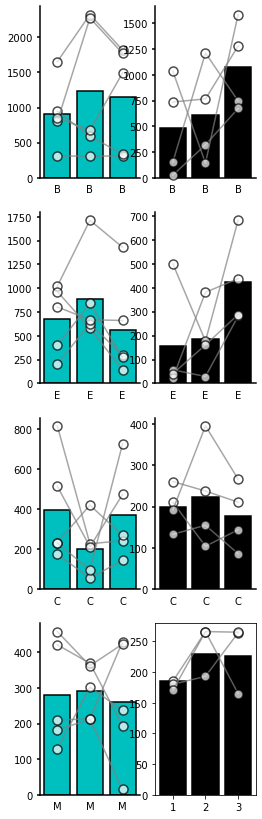

In [21]:
colors_PR=['c']
colors_NR=['black']

f,ax=plt.subplots(figsize=(5,15), ncols=2, nrows=4, sharey=False)
f.subplots_adjust(wspace=0.15, bottom=0.15, left=0.3)

# Baseline PR
tp.barscatter([total_licks_S1_PR,total_licks_S2_PR,total_licks_S3_PR], 
              paired= True,
              barfacecolor=colors_PR,
              barlabels=['B','B','B'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])



# Baseline NR

tp.barscatter([total_licks_S1_NR,total_licks_S2_NR,total_licks_S3_NR], 
              paired= True,
              barfacecolor=colors_NR,
              barlabels=['B','B','B'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])


# Ensure PR
tp.barscatter([total_licks_S1_PR_E,total_licks_S2_PR_E,total_licks_S3_PR_E], 
              paired= True,
              barfacecolor = colors_PR,
              barlabels=['E','E','E'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

#  Ensure NR
tp.barscatter([total_licks_S1_NR_E,total_licks_S2_NR_E,total_licks_S3_NR_E], 
              paired= True,
              barfacecolor = colors_NR,
              barlabels=['E','E','E'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#  Cas PR
tp.barscatter([total_licks_S1_PR_C,total_licks_S2_PR_C,total_licks_S3_PR_C], 
              paired= True,
              barfacecolor = colors_PR,
              barlabels=['C','C','C'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])
#  Cas NR
tp.barscatter([total_licks_S1_NR_C,total_licks_S2_NR_C,total_licks_S3_NR_C], 
              paired= True,
              barfacecolor = colors_NR,
              barlabels=['C','C','C'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])

#  Malt PR
tp.barscatter([total_licks_S1_PR_M,total_licks_S2_PR_M,total_licks_S3_PR_M], 
              paired= True,
              barfacecolor = colors_PR,
              barlabels=['M','M','M'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3,0])
#  Cas NR
tp.barscatter([total_licks_S1_NR_M,total_licks_S2_NR_M,total_licks_S3_NR_M], 
              paired= True,
              barfacecolor = colors_NR,
              barlabels=['M','M','M'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3,1])

ax[0,0].set_ylabel('Number of licks',fontsize = 15)
ax[0,0].set_yticks([500,1500,2500])
ax[0,1].set_yticks([500,1500,2500])
ax[1,0].set_yticks([500,1500,2000])
ax[1,1].set_yticks([500,1500,2000])
ax[2,0].set_yticks([200,400,600,800])
ax[2,1].set_yticks([200,400,600,800])
ax[3,0].set_yticks([0,250,500])
ax[3,1].set_yticks([0,250,500])


Gjennomsnitt dyr 

In [30]:
total_licks_NR=[]
total_licks_PR=[]
total_licks_NR_E=[]
total_licks_PR_E=[]
total_licks_NRPR_E=[]
total_licks_PRNR_E=[]
total_licks_PR_C=[]
total_licks_NR_C=[]
total_licks_NRPR_C=[]
total_licks_PRNR_C=[]
total_licks_PR_M=[]
total_licks_NR_M=[]
total_licks_NRPR_M=[]
total_licks_PRNR_M=[]

for mouse in mice:
    temp_licks_NR=[]
    temp_licks_PR=[]
    temp_licks_NR_E=[]
    temp_licks_PR_E=[]
    temp_licks_NRPR_E=[]
    temp_licks_PRNR_E=[]
    temp_licks_PR_C=[]
    temp_licks_NR_C=[]
    temp_licks_NRPR_C=[]
    temp_licks_PRNR_C=[]
    temp_licks_PR_M=[]
    temp_licks_NR_M=[]
    temp_licks_NRPR_M=[]
    temp_licks_PRNR_M=[]
    
    for key in all_data.keys(): 
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'PR':
            temp_licks_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_licks_NR.append(d['total licks'])
            
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PR':
            temp_licks_PR_E.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']== 'Ensure' and d['diet']== 'NR':
            temp_licks_NR_E.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_licks_PRNR_E.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']== 'Ensure' and d['diet']== 'NRPR':
            temp_licks_NRPR_E.append(d['total licks'])
            
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'PR':
            temp_licks_PR_C.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'NR':
            temp_licks_NR_C.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_licks_PRNR_C.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'NRPR':
            temp_licks_NRPR_C.append(d['total licks'])
            
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'PR':
            temp_licks_PR_M.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'NR':
            temp_licks_NR_M.append(d['total licks'])   
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_licks_PRNR_M.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'NRPR':
            temp_licks_NRPR_M.append(d['total licks'])

    
    if len(temp_licks_PR)>0:
        total_licks_PR.append(np.mean(temp_licks_PR))
    if len(temp_licks_NR)>0:
        total_licks_NR.append(np.mean(temp_licks_NR))
        
    if len(temp_licks_PR_E)>0: 
        total_licks_PR_E.append(np.mean(temp_licks_PR_E))
    if len(temp_licks_NR_E)>0: 
        total_licks_NR_E.append(np.mean(temp_licks_NR_E))
    if len(temp_licks_PRNR_E)>0: 
        total_licks_PRNR_E.append(np.mean(temp_licks_PRNR_E))
    if len(temp_licks_NRPR_E)>0: 
        total_licks_NRPR_E.append(np.mean(temp_licks_NRPR_E))
        
    if len(temp_licks_PR_C)>0: 
        total_licks_PR_C.append(np.mean(temp_licks_PR_C))
    if len(temp_licks_NR_C)>0: 
        total_licks_NR_C.append(np.mean(temp_licks_NR_C))
    if len(temp_licks_PRNR_C)>0: 
        total_licks_PRNR_C.append(np.mean(temp_licks_PRNR_C))
    if len(temp_licks_NRPR_C)>0: 
        total_licks_NRPR_C.append(np.mean(temp_licks_NRPR_C))
        
    if len(temp_licks_NR_M)>0: 
        total_licks_NR_M.append(np.mean(temp_licks_NR_M))
    if len(temp_licks_PR_M)>0: 
        total_licks_PR_M.append(np.mean(temp_licks_PR_M))
    if len(temp_licks_PRNR_M)>0: 
        total_licks_PRNR_M.append(np.mean(temp_licks_PRNR_M))
    if len(temp_licks_NRPR_M)>0: 
        total_licks_NRPR_M.append(np.mean(temp_licks_NRPR_M))
        
# print(total_licks_PR,total_licks_NR)
# print(total_licks_PR_E,total_licks_NR_E,total_licks_PRNR_E,total_licks_NRPR_E)
# print(total_licks_PR_C,total_licks_NR_C,total_licks_PRNR_C,total_licks_NRPR_C)
print(total_licks_PR_M,total_licks_NR_M,total_licks_PRNR_M,total_licks_NRPR_M)



[274.6666666666667, 146.0, 222.33333333333334, 414.3333333333333, 328.0] [209.0, 222.5, 207.5, 205.33333333333334] [457.0, 204.66666666666666, 225.5, 265.5, 243.0] [207.33333333333334, 235.66666666666666, 134.0]


C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: barfacecoloroption is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))
C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: xfontsize is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))
C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: barfacecoloroption is not a functional keyword argument. Check spelling or barscatter version.
  warnings.warn("{} is not a functional keyword argument. Check spelling or barscatter version.".format(key))
C:\Users\mko102\Anaconda3\lib\site-packages\trompy\barscatter.py:304: UserWarning: xfontsize is not a functional keyword argument. Check spelling

Text(0.5, 1.0, 'Maltodextrin')

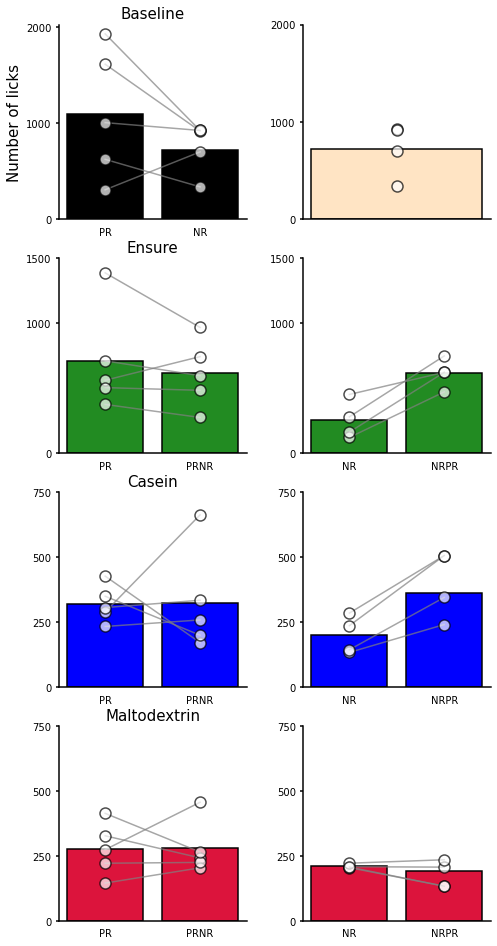

In [25]:
colors_PR_B=['bisque','orange']
colors_PR_E=['forestgreen','darkgreen']
colors_PR_C=['blue','darkblue']
colors_PR_M=['crimson','darkred']
colors_NR=['black','grey']

f,ax=plt.subplots(figsize=(10,15), ncols=2, nrows=4, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.05, left=0.3)

#Baseline
tp.barscatter([total_licks_PR,total_licks_NR], 
              paired= True,
              barfacecolor=colors_NR,
              barlabels=['PR','NR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([total_licks_NR], 
              paired= True,
              barfacecolor=colors_PR_B,
              barlabels=['PR','NR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])

tp.barscatter([total_licks_PR_E, total_licks_PRNR_E], 
              paired= True,
              barfacecolor = colors_PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([total_licks_NR_E, total_licks_NRPR_E], 
              paired= True,
              barfacecolor = colors_PR_E,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

tp.barscatter([total_licks_PR_C, total_licks_PRNR_C], 
              paired= True,
              barfacecolor = colors_PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([total_licks_NR_C, total_licks_NRPR_C], 
              paired= True,
              barfacecolor = colors_PR_C,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])


tp.barscatter([total_licks_PR_M, total_licks_PRNR_M], 
              paired= True,
              barfacecolor = colors_PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3,0])

tp.barscatter([total_licks_NR_M, total_licks_NRPR_M], 
              paired= True,
              barfacecolor = colors_PR_M,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3,1])

ax[0,0].set_ylabel('Number of licks',fontsize = 15)
ax[0,0].set_yticks([0,1000,2000]),ax[0,1].set_yticks([0,1000,2000])
ax[1,0].set_yticks([0,1000,1500]),ax[1,1].set_yticks([0,1000,1500])
ax[2,0].set_yticks([0,250,500,750]),ax[2,1].set_yticks([0,250,500,750])
ax[3,0].set_yticks([0,250,500,750]),ax[3,1].set_yticks([0,250,500,750])



ax[0,0].set_title('Baseline', fontsize =15)
ax[1,0].set_title('Ensure', fontsize =15)
ax[2,0].set_title('Casein', fontsize =15)
ax[3,0].set_title('Maltodextrin', fontsize =15)

In [1]:
colors_PR=['black','forestgreen','blue','crimson']
colors_NR=['darkgreen','darkblue','darkred']


f,ax=plt.subplots (figsize=(9,6), ncols=2, nrows=2, sharey=True)
f.subplots_adjust(wspace=0.2, hspace=0.5, bottom=0.15, left=0.3)

#PR 
tp.barscatter([total_licks_PR_E,total_licks_PR_C,total_licks_PR_M],
              paired=True,
              barlabels=['E','C','M'],
              barlabeloffset=0.04,
              xfontsize=15,
              barfacecolor=colors_PR, 
              barfacecoloroption="individual",
              scattersize=110, 
              scatteralpha=0.7, 
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])
#PRNR
tp.barscatter([total_licks_NR_E,total_licks_NR_C,total_licks_NR_M],
              paired=True,
              barlabels=['E','C','M'],
              barlabeloffset=0.04,
              xfontsize=15,
              barfacecolor=colors_NR, 
              barfacecoloroption="individual",
              scattersize=110, 
              scatteralpha=0.7, 
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#NR
tp.barscatter([total_licks_PRNR_E,total_licks_PRNR_C,total_licks_PRNR_M],
              paired=True,
              barlabels=['E','C','M'],
              barlabeloffset=0.04,
              xfontsize=15,
              barfacecolor=colors_NR, 
              barfacecoloroption="individual",
              scattersize=110, 
              scatteralpha=0.7, 
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])


#NRPR
tp.barscatter([total_licks_NRPR_E,total_licks_NRPR_C,total_licks_NRPR_M],
              paired=True,
              barlabels=['E','C','M'],
              barlabeloffset=0.04,
              xfontsize=15,
              barfacecolor=colors_PR, 
              barfacecoloroption="individual",
              scattersize=110, 
              scatteralpha=0.7, 
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])


ax[0,0].set_ylabel('Total licks',fontsize = 15)


ax[1,0].set_ylabel('Total licks',fontsize = 15)


ax[0,0].set_title('PR', fontsize =15)
ax[0,1].set_title('PRNR', fontsize =15)
ax[1,0].set_title('NR', fontsize =15)
ax[1,1].set_title('NRPR', fontsize =15)



NameError: name 'plt' is not defined

In [ ]:

# print('Total Licks')
# print('NR_B ',np.mean(total_licks_NR), '-',np.std(total_licks_NR, ddof=1) / np.sqrt(np.size(total_licks_NR)))
# print('PR_B ',np.mean(total_licks_PR), '-',np.std(total_licks_PR, ddof=1) / np.sqrt(np.size(total_licks_PR)))
# print('PR_E', np.mean(total_licks_PR_E), '-', np.std(total_licks_PR_E, ddof=1) / np.sqrt(np.size(total_licks_PR_E)))
# print('NR_E', np.mean(total_licks_NR_E), '-', np.std(total_licks_NR_E, ddof=1) / np.sqrt(np.size(total_licks_NR_E)))

# t_value,p_value=stats.ttest_ind(total_licks_PR,total_licks_NR)
# print('T-test (PR NR_B) = %f'%p_value)

# t_value,p_value=stats.ttest_ind(total_licks_PR_E,total_licks_NR_E)
# print('T-test(PR NR_E) = %f'%p_value)

# t_value,p_value=stats.ttest_ind(total_licks_PR,total_licks_PR_E)
# print('T-test(PR_B-E) = %f'%p_value)

# t_value,p_value=stats.ttest_ind(total_licks_NR,total_licks_NR_E)
# print('T-test(NR_B-E) = %f'%p_value)

## Licks per trial

Session 1

In [ ]:
licks_per_trial_S1_PR=[]
licks_per_trial_S1_NR=[]

licks_per_trial_S1_PR_E=[]
licks_per_trial_S1_NR_E=[]

licks_per_trial_S1_PR_C=[]
licks_per_trial_S1_NR_C=[]

licks_per_trial_S1_PR_M=[]
licks_per_trial_S1_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S1'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            licks_per_trial_S1_PR.append(d['licks per trial'])
        elif d['diet']== 'NR': 
            licks_per_trial_S1_NR.append(d['licks per trial'])
            
    if d['session']=='S1'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            licks_per_trial_S1_PR_E.append(d['licks per trial'])
        elif d['diet']== 'NR': 
            licks_per_trial_S1_NR_E.append(d['licks per trial'])

    if d['session']== 'S1' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            licks_per_trial_S1_PR_C.append(d['licks per trial'])
        elif d['diet']== 'NR':
            licks_per_trial_S1_NR_C.append(d['licks per trial'])
     
    if d['session']== 'S1' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            licks_per_trial_S1_PR_M.append(d['licks per trial'])
        elif d['diet']== 'NR':
            licks_per_trial_S1_NR_M.append(d['licks per trial'])
            
print(licks_per_trial_S1_PR,licks_per_trial_S1_NR )  
print(licks_per_trial_S1_PR_E,licks_per_trial_S1_NR_E)
print(licks_per_trial_S1_PR_C,licks_per_trial_S1_NR_C)
print(licks_per_trial_S1_PR_M,licks_per_trial_S1_NR_M)

Session 2 

In [ ]:
licks_per_trial_S2_PR=[]
licks_per_trial_S2_NR=[]

licks_per_trial_S2_PR_E=[]
licks_per_trial_S2_NR_E=[]

licks_per_trial_S2_PR_C=[]
licks_per_trial_S2_NR_C=[]

licks_per_trial_S2_PR_M=[]
licks_per_trial_S2_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S2'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            licks_per_trial_S2_PR.append(d['licks per trial'])
        elif d['diet']== 'NR': 
            licks_per_trial_S2_NR.append(d['licks per trial'])
            
    if d['session']=='S2'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            licks_per_trial_S2_PR_E.append(d['licks per trial'])
        elif d['diet']== 'NR': 
            licks_per_trial_S2_NR_E.append(d['licks per trial'])

    if d['session']== 'S2' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            licks_per_trial_S2_PR_C.append(d['licks per trial'])
        elif d['diet']== 'NR':
            licks_per_trial_S2_NR_C.append(d['licks per trial'])
     
    if d['session']== 'S2' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            licks_per_trial_S2_PR_M.append(d['licks per trial'])
        elif d['diet']== 'NR':
            licks_per_trial_S2_NR_M.append(d['licks per trial'])
            
print(licks_per_trial_S2_PR,licks_per_trial_S2_NR )  
print(licks_per_trial_S2_PR_E,licks_per_trial_S2_NR_E)
print(licks_per_trial_S2_PR_C,licks_per_trial_S2_NR_C)
print(licks_per_trial_S2_PR_M,licks_per_trial_S2_NR_M)

Session 3

In [ ]:
licks_per_trial_S3_PR=[]
licks_per_trial_S3_NR=[]

licks_per_trial_S3_PR_E=[]
licks_per_trial_S3_NR_E=[]

licks_per_trial_S3_PR_C=[]
licks_per_trial_S3_NR_C=[]

licks_per_trial_S3_PR_M=[]
licks_per_trial_S3_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S3'and d['solution']== 'Baseline':
        if d['diet']=='PR':
            licks_per_trial_S3_PR.append(d['licks per trial'])
        elif d['diet']== 'NR': 
            licks_per_trial_S3_NR.append(d['licks per trial'])
            
    if d['session']=='S3'and d['solution']== 'Ensure':
        if d['diet']=='PR':
            licks_per_trial_S3_PR_E.append(d['licks per trial'])
        elif d['diet']== 'NR': 
            licks_per_trial_S3_NR_E.append(d['licks per trial'])

    if d['session']== 'S3' and d['solution']== 'Cas':
        if d['diet']== 'PR': 
            licks_per_trial_S3_PR_C.append(d['licks per trial'])
        elif d['diet']== 'NR':
            licks_per_trial_S3_NR_C.append(d['licks per trial'])
     
    if d['session']== 'S3' and d['solution']== 'Malt.':
        if d['diet']== 'PR': 
            licks_per_trial_S3_PR_M.append(d['licks per trial'])
        elif d['diet']== 'NR':
            licks_per_trial_S3_NR_M.append(d['licks per trial'])
            
print(licks_per_trial_S3_PR,licks_per_trial_S3_NR )  
print(licks_per_trial_S3_PR_E,licks_per_trial_S3_NR_E)
print(licks_per_trial_S3_PR_C,licks_per_trial_S3_NR_C)
print(licks_per_trial_S3_PR_M,licks_per_trial_S3_NR_M)
       

Plot trials

In [ ]:
colors_PR=['c']
colors_NR=['black']

f,ax=plt.subplots(figsize=(25,3), ncols=8, sharey=True)
f.subplots_adjust(wspace=0.15, bottom=0.15, left=0.3)

# Baseline PR
tp.barscatter([licks_per_trial_S1_PR,licks_per_trial_S1_PR,licks_per_trial_S3_PR], 
#               paired= True,
              barfacecolor=colors_PR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0])



# Baseline NR

tp.barscatter([licks_per_trial_S1_NR,licks_per_trial_S1_NR,licks_per_trial_S3_NR], 
#               paired= True,
              barfacecolor=colors_NR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1])


# Ensure PR
tp.barscatter([licks_per_trial_S1_PR_E,licks_per_trial_S1_PR_E,licks_per_trial_S3_PR_E], 
#               paired= True,
              barfacecolor = colors_PR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2])

#  Ensure NR
tp.barscatter([licks_per_trial_S1_NR_E,licks_per_trial_S1_NR_E,licks_per_trial_S3_NR_E], 
#               paired= True,
              barfacecolor = colors_NR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3])

#  Cas PR
tp.barscatter([licks_per_trial_S1_PR_C,licks_per_trial_S1_PR_C,licks_per_trial_S3_PR_C], 
#               paired= True,
              barfacecolor = colors_PR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[4])
#  Cas NR
tp.barscatter([licks_per_trial_S1_NR_C,licks_per_trial_S1_NR_C,licks_per_trial_S3_NR_C], 
              paired= True,
              barfacecolor = colors_NR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[5])

#  Malt PR
tp.barscatter([licks_per_trial_S1_PR_M,licks_per_trial_S1_PR_M,licks_per_trial_S3_PR_M], 
#               paired= True,
              barfacecolor = colors_PR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[6])
#  Cas NR
tp.barscatter([licks_per_trial_S1_NR_M,licks_per_trial_S1_NR_M,licks_per_trial_S3_NR_M], 
#               paired= True,
              barfacecolor = colors_NR,
              barlabels=['S1','S2','S3'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=90,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[7])

ax[0].set_ylabel('Number of licks',fontsize = 15)
ax[0].set_yticks([10,20,30,40,50])


ax[0].set_yticklabels([10,20,30,40,50], fontsize = 15)


Mean for each animal

In [ ]:
licks_per_trial_NR=[]
licks_per_trial_PR=[]

licks_per_trial_NR_E=[]
licks_per_trial_PR_E=[]
licks_per_trial_NRPR_E=[]
licks_per_trial_PRNR_E=[]

licks_per_trial_PR_C=[]
licks_per_trial_NR_C=[]
licks_per_trial_NRPR_C=[]
licks_per_trial_PRNR_C=[]

licks_per_trial_PR_M=[]
licks_per_trial_NR_M=[]
licks_per_trial_NRPR_M=[]
licks_per_trial_PRNR_M=[]

for mouse in mice:
    temp_licks_NR=[]
    temp_licks_PR=[]
    temp_licks_NR_E=[]
    temp_licks_PR_E=[]
    temp_licks_NRPR_E=[]
    temp_licks_PRNR_E=[]
    temp_licks_PR_C=[]
    temp_licks_NR_C=[]
    temp_licks_NRPR_C=[]
    temp_licks_PRNR_C=[]
    temp_licks_PR_M=[]
    temp_licks_NR_M=[]
    temp_licks_NRPR_M=[]
    temp_licks_PRNR_M=[]
    
    for key in all_data.keys(): 
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'PR':
            temp_licks_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_licks_NR.append(d['licks per trial'])
            
            
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PR':
            temp_licks_PR_E.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Ensure' and d['diet']== 'NR':
            temp_licks_NR_E.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_licks_PRNR_E.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Ensure' and d['diet']== 'NRPR':
            temp_licks_NRPR_E.append(d['licks per trial'])
            
            
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'PR':
            temp_licks_PR_C.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'NR':
            temp_licks_NR_C.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'PRNR':
            temp_licks_PRNR_C.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Cas' and d['diet']== 'NRPR':
            temp_licks_NRPR_C.append(d['licks per trial'])   
            
            
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'PR':
            temp_licks_PR_M.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'NR':
            temp_licks_NR_M.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'PRNR':
            temp_licks_PRNR_M.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']== 'Malt.' and d['diet']== 'NRPR':
            temp_licks_NRPR_M.append(d['licks per trial']) 

    
    if len(temp_licks_PR)>0:
        licks_per_trial_PR.append(np.mean(temp_licks_PR))
    if len(temp_licks_NR)>0:
        licks_per_trial_NR.append(np.mean(temp_licks_NR))
        
    if len(temp_licks_PR_E)>0: 
        licks_per_trial_PR_E.append(np.mean(temp_licks_PR_E))
    if len(temp_licks_NR_E)>0: 
        licks_per_trial_NR_E.append(np.mean(temp_licks_NR_E))
    if len(temp_licks_PRNR_E)>0: 
        licks_per_trial_PRNR_E.append(np.mean(temp_licks_PRNR_E))
    if len(temp_licks_NRPR_E)>0: 
        licks_per_trial_NRPR_E.append(np.mean(temp_licks_NRPR_E))    
        
    if len(temp_licks_PR_C)>0: 
        licks_per_trial_PR_C.append(np.mean(temp_licks_PR_C))
    if len(temp_licks_NR_C)>0: 
        licks_per_trial_NR_C.append(np.mean(temp_licks_NR_C))
    if len(temp_licks_PRNR_C)>0: 
        licks_per_trial_PRNR_C.append(np.mean(temp_licks_PRNR_C))
    if len(temp_licks_NRPR_C)>0: 
        licks_per_trial_NRPR_C.append(np.mean(temp_licks_NRPR_C)) 
        
    if len(temp_licks_NR_M)>0: 
        licks_per_trial_NR_M.append(np.mean(temp_licks_NR_M))
    if len(temp_licks_PR_C)>0: 
        licks_per_trial_PR_M.append(np.mean(temp_licks_PR_M))
    if len(temp_licks_PRNR_M)>0: 
        licks_per_trial_PRNR_M.append(np.mean(temp_licks_PRNR_M))
    if len(temp_licks_NRPR_M)>0: 
        licks_per_trial_NRPR_M.append(np.mean(temp_licks_NRPR_M)) 
        
print(np.mean(licks_per_trial_PR),np.mean(licks_per_trial_NR))

print('Ensure', 'PR', np.mean(licks_per_trial_PR_E),
      'NR', np.mean(licks_per_trial_NR_E), 
      'PRNR', np.mean(licks_per_trial_PRNR_E), 
      'NRPR', np.mean(licks_per_trial_NRPR_E))

print('Cas', 'PR', np.mean(licks_per_trial_PR_C),
      'NR', np.mean(licks_per_trial_NR_C), 
      'PRNR', np.mean(licks_per_trial_PRNR_C), 
      'NRPR', np.mean(licks_per_trial_NRPR_C))

print('Malt', 'PR', np.mean(licks_per_trial_PR_M),
      'NR', np.mean(licks_per_trial_NR_M), 
      'PRNR', np.mean(licks_per_trial_PRNR_M), 
      'NRPR', np.mean(licks_per_trial_NRPR_M))


Plot

In [ ]:
colors_B=['c','black']
colors_E=['c','black']

f,ax=plt.subplots(figsize=(15,3), ncols=4, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.15, left=0.3)


tp.barscatter([licks_per_trial_PR, licks_per_trial_NR], 
#               paired= True,
              barfacecolor=colors_B,
              barlabels=['PR_B','NR_B'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0])

tp.barscatter([licks_per_trial_PR_E, licks_per_trial_NR_E], 
#               paired= True,
              barfacecolor = colors_E,
              barlabels=['PR_E','NR_E'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1])

tp.barscatter([licks_per_trial_PR_C, licks_per_trial_NR_C], 
#               paired= True,
              barfacecolor = colors_E,
              barlabels=['NR_C','PR_C'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2])

tp.barscatter([licks_per_trial_PR_M, licks_per_trial_NR_M], 
#               paired= True,
              barfacecolor = colors_E,
              barlabels=['PR_M','PR_M'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3])
ax[0].set_ylabel('Licks per trial',fontsize = 15)

### Licks Hz - trial

Session 1

In [ ]:
licks_Hz_S1_PR=[]
licks_Hz_S1_NR=[]

licks_Hz_S1_PR_E=[]
licks_Hz_S1_NR_E=[]

licks_Hz_S1_PR_C=[]
licks_Hz_S1_NR_C=[]

licks_Hz_S1_PR_M=[]
licks_Hz_S1_NR_M=[]



for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S1' and d['solution']=='Baseline':
        if d['diet']=='PR':
            licks_Hz_S1_PR.append(d['licks Hz'])
        elif d['diet']== 'NR': 
            licks_Hz_S1_NR.append(d['licks Hz'])
    if d['session']=='S1' and d['solution']== 'Ensure':
        if d['diet']=='PR':
            licks_Hz_S1_PR_E.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S1_NR_E.append(d['licks Hz'])
            
    if d['session']=='S1' and d['solution']== 'Cas':
        if d['diet']=='PR':
            licks_Hz_S1_PR_C.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S1_NR_C.append(d['licks Hz'])
            
    if d['session']=='S1' and d['solution']== 'Malt.':
        if d['diet']=='PR':
            licks_Hz_S1_PR_M.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S1_NR_M.append(d['licks Hz'])


Session 2 

In [ ]:
licks_Hz_S2_PR=[]
licks_Hz_S2_NR=[]

licks_Hz_S2_PR_E=[]
licks_Hz_S2_NR_E=[]

licks_Hz_S2_PR_C=[]
licks_Hz_S2_NR_C=[]

licks_Hz_S2_PR_M=[]
licks_Hz_S2_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S2' and d['solution']=='Baseline':
        if d['diet']=='PR':
            licks_Hz_S2_PR.append(d['licks Hz'])
        elif d['diet']== 'NR': 
            licks_Hz_S2_NR.append(d['licks Hz'])
            
    if d['session']=='S2' and d['solution']== 'Ensure':
        if d['diet']=='PR':
            licks_Hz_S2_PR_E.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S2_NR_E.append(d['licks Hz'])
            
    if d['session']=='S2' and d['solution']== 'Cas':
        if d['diet']=='PR':
            licks_Hz_S2_PR_C.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S2_NR_C.append(d['licks Hz'])
            
    if d['session']=='S2' and d['solution']== 'Malt.':
        if d['diet']=='PR':
            licks_Hz_S2_PR_M.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S2_NR_M.append(d['licks Hz'])
            


Session 3

In [ ]:
licks_Hz_S3_PR=[]
licks_Hz_S3_NR=[]

licks_Hz_S3_PR_E=[]
licks_Hz_S3_NR_E=[]

licks_Hz_S3_PR_C=[]
licks_Hz_S3_NR_C=[]

licks_Hz_S3_PR_M=[]
licks_Hz_S3_NR_M=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['session']=='S3' and d['solution']=='Baseline':
        if d['diet']=='PR':
            licks_Hz_S3_PR.append(d['licks Hz'])
        elif d['diet']== 'NR': 
            licks_Hz_S3_NR.append(d['licks Hz'])
            
    if d['session']=='S3' and d['solution']== 'Ensure':
        if d['diet']=='PR':
            licks_Hz_S3_PR_E.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S3_NR_E.append(d['licks Hz'])
            
    if d['session']=='S3' and d['solution']== 'Cas':
        if d['diet']=='PR':
            licks_Hz_S3_PR_C.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S3_NR_C.append(d['licks Hz'])
            
    if d['session']=='S3' and d['solution']== 'Malt.':
        if d['diet']=='PR':
            licks_Hz_S3_PR_M.append(d['licks Hz'])
        elif d['diet']=='NR':
            licks_Hz_S3_NR_M.append(d['licks Hz'])
            
            

Gjennomsnitt

In [ ]:
PR_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_PR,licks_Hz_S2_PR,licks_Hz_S3_PR)]
NR_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_NR,licks_Hz_S2_NR,licks_Hz_S3_NR)]

PR_E_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_PR_E,licks_Hz_S2_PR_E,licks_Hz_S3_PR_E)]
NR_E_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_NR_E,licks_Hz_S2_NR_E,licks_Hz_S3_NR_E)]

PR_C_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_PR_C,licks_Hz_S2_PR_C,licks_Hz_S3_PR_C)]
NR_C_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_NR_C,licks_Hz_S2_NR_C,licks_Hz_S3_NR_C)]

PR_M_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_PR_M,licks_Hz_S2_PR_M,licks_Hz_S3_PR_M)]
NR_M_Licks_Hz_all = [sum(sub_list) / len(sub_list) for sub_list in zip(licks_Hz_S1_NR_M,licks_Hz_S2_NR_M,licks_Hz_S3_NR_M)]


In [ ]:
y1=np.mean(PR_Licks_Hz_all,axis=0)
y2=np.mean(NR_Licks_Hz_all,axis=0)

y3=np.mean(PR_E_Licks_Hz_all,axis=0)
y4=np.mean(NR_E_Licks_Hz_all,axis=0)

y5=np.mean(PR_C_Licks_Hz_all,axis=0)
y6=np.mean(NR_C_Licks_Hz_all,axis=0)

y7=np.mean(PR_M_Licks_Hz_all,axis=0)
y8=np.mean(NR_M_Licks_Hz_all,axis=0)

f,[ax1,ax2,ax3,ax4]=plt.subplots(figsize=(6,8), nrows=4, sharex=True)
f.subplots_adjust(wspace=0.15, bottom=0.15, left=0.1)

ax1.plot(y1,color='darkcyan',label='PR')
ax1.plot(y2,color='black', label='NR',alpha=0.9)

ax1.set_xticks([0,50,100,150,200])

ax1.set_yticks([0,1.0,2.0])
ax1.set_yticklabels([0,1,2], fontsize=15)

ax1.axvspan(50,100, facecolor='lightgrey', alpha=0.5)
ax1.axvspan(100,120, facecolor='lightgrey', alpha=0.2)



ax1.legend(fontsize = 10)

ax2.plot(y3,color='c', label='PR_E')
ax2.plot(y4,color='gray',label='NR_E')

ax2.set_xticks([0,50,100,150,200,250])
ax2.set_xticklabels(['-5','0','5','10','15','20'], fontsize = 15)

ax2.set_yticks([0,1.0,2.0])
ax2.set_yticklabels([0,1,2], fontsize=15)

ax2.axvspan(50,100, facecolor='lightgrey', alpha=0.5)
ax2.axvspan(100,120, facecolor='lightgrey', alpha=0.2)
ax2.legend(fontsize = 10)



ax3.plot(y5,color='c', label='PR_C')
ax3.plot(y6,color='gray',label='NR_C')

ax3.set_xticks([0,50,100,150,200,250])
ax3.set_xticklabels(['-5','0','5','10','15','20'], fontsize = 15)

ax3.set_yticks([0,0.5,1.0])
ax3.set_yticklabels([0,0.5,1], fontsize=15)

ax3.axvspan(50,100, facecolor='lightgrey', alpha=0.5)
ax3.axvspan(100,120, facecolor='lightgrey', alpha=0.2)
ax3.legend(fontsize = 10)


ax4.plot(y7,color='c', label='PR_M')
ax4.plot(y8,color='gray',label='NR_M')

ax4.set_xticks([0,50,100,150,200,250])
ax4.set_xticklabels(['-5','0','5','10','15','20'], fontsize = 15)

ax4.set_yticks([0,0.5,1.0])
ax4.set_yticklabels([0,0.5,1], fontsize=15)

ax4.axvspan(50,100, facecolor='lightgrey', alpha=0.5)
ax4.axvspan(100,120, facecolor='lightgrey', alpha=0.2)
ax4.legend(fontsize = 10)

ax4.set_xlabel('Time from cue (sec)', fontsize=15)
ax1.set_ylabel('Licks Hz', fontsize=15)
ax2.set_ylabel('Licks Hz', fontsize =15)

# f.savefig('fig\\Ensure Hz2.pdf')

## Latency to first lick

Session 1

In [ ]:
latency_S1_PR=[]
latency_S1_NR=[]


for key in all_data.keys(): 
    d=all_data[key]
    if d['day']=='D1':
        if d['diet']=='PR':
            latency_S1_PR.append(np.mean(d['latency']))
        elif d['diet']== 'NR': 
            latency_S1_NR.append(np.mean(d['latency']))


Session 2

In [ ]:
latency_S2_PR=[]
latency_S2_NR=[]


for key in all_data.keys(): 
    d=all_data[key]
    if d['day']=='D3':
        if d['diet']=='PR':
            latency_S2_PR.append(np.mean(d['latency']))
        elif d['diet']== 'NR': 
            latency_S2_NR.append(np.mean(d['latency']))
       


Session 3

In [ ]:
latency_S3_PR=[]
latency_S3_NR=[]

for key in all_data.keys(): 
    d=all_data[key]
    if d['day']=='D5':
        if d['diet']=='PR':
            latency_S3_PR.append(np.mean(d['latency']))
        elif d['diet']== 'NR': 
            latency_S3_NR.append(np.mean(d['latency']))



Gjennomsnitt

In [ ]:
Latency_NR=[]
Latency_PR=[]


for mouse in mice:
    temp_licks_NR=[]
    temp_licks_PR=[]
   
    
    for key in all_data.keys(): 
        d=all_data[key]
        if d['mouse']==mouse and d['phase']=='Baseline' and d['diet']== 'PR':
            temp_licks_PR.append(np.mean(d['latency']))
        elif d['mouse']==mouse and d['phase']=='Baseline' and d['diet']== 'NR':
            temp_licks_NR.append(np.mean(d['latency']))
     
    
    if len(temp_licks_PR)>0:
        Latency_PR.append(np.mean(temp_licks_PR))
    if len(temp_licks_NR)>0:
        Latency_NR.append(np.mean(temp_licks_NR))

        

In [ ]:
print(Latency_NR,Latency_PR)

Stats

In [ ]:
print('Latency')
print('NR ',np.mean(Latency_NR), '-',np.std(Latency_NR, ddof=1) / np.sqrt(np.size(Latency_NR)))
print('PR ',np.mean(Latency_PR), '-',np.std(Latency_PR, ddof=1) / np.sqrt(np.size(Latency_PR)))



t_value,p_value=stats.ttest_ind(Latency_PR,Latency_NR)
print('T-test (PR NR) = %f'%p_value)



In [ ]:
colors_PR=['darkcyan','c']
colors_NR=['black','grey']

f,ax=plt.subplots(figsize=(6,4), ncols=2, sharey=True)
f.subplots_adjust(wspace=0.15, bottom=0.15, left=0.2, top=0.65)
f.suptitle('Latency to first lick', y=0.9, fontsize=20)


tp.barscatter([Latency_PR], 
              paired= True,
              barfacecolor=colors_PR,
              barlabels=['PR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0])

tp.barscatter([Latency_NR], 
              paired= True,
              barfacecolor = colors_NR,
              barlabels=['NR'],
              barlabeloffset=0.04,
              barfacecoloroption="individual",
              xfontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1])

ax[0].set_ylabel('Sec',fontsize = 15)
ax[0].set_yticks([0,2.5,5,7.5])
ax[0].set_yticklabels([0,2.5,5.0,7.5], fontsize = 15)
ax[0].axhline(y=5,color='brown',linestyle='--')

ax[1].set_yticks([0,2.5,5,7.5])
ax[1].axhline(y=5,color='brown',linestyle='--')


